In [16]:
#importing libraries
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.preprocessing.image import load_img
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPool2D, MaxPooling2D
from keras import layers
from keras.layers import BatchNormalization
from keras.optimizers import RMSprop
from keras.regularizers import l2
from keras.callbacks import ModelCheckpoint,EarlyStopping
from glob import glob
import pathlib
import os


In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [3]:
#unzip the dataset
!unzip "/content/gdrive/MyDrive/CNN_asignment.zip" > /dev/null

In [4]:
#paths for images (train & test images)
train_folder = pathlib.Path("/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/")
test_folder = pathlib.Path("/content/Skin cancer ISIC The International Skin Imaging Collaboration/Test/")

In [5]:
#Creating training & test data set from available images
train_images = keras.preprocessing.image_dataset_from_directory(train_folder, batch_size=32,
                                                               image_size=(180,180), label_mode='categorical',
                                                               seed=123,subset="training",
                                                               validation_split=0.2)

Found 2239 files belonging to 9 classes.
Using 1792 files for training.


In [6]:
val_images =tf.keras.preprocessing.image_dataset_from_directory(train_folder,batch_size=32,
                                                            image_size=(180,180), label_mode='categorical',
                                                            seed=123,subset="validation",
                                                            validation_split=0.2)

Found 2239 files belonging to 9 classes.
Using 447 files for validation.


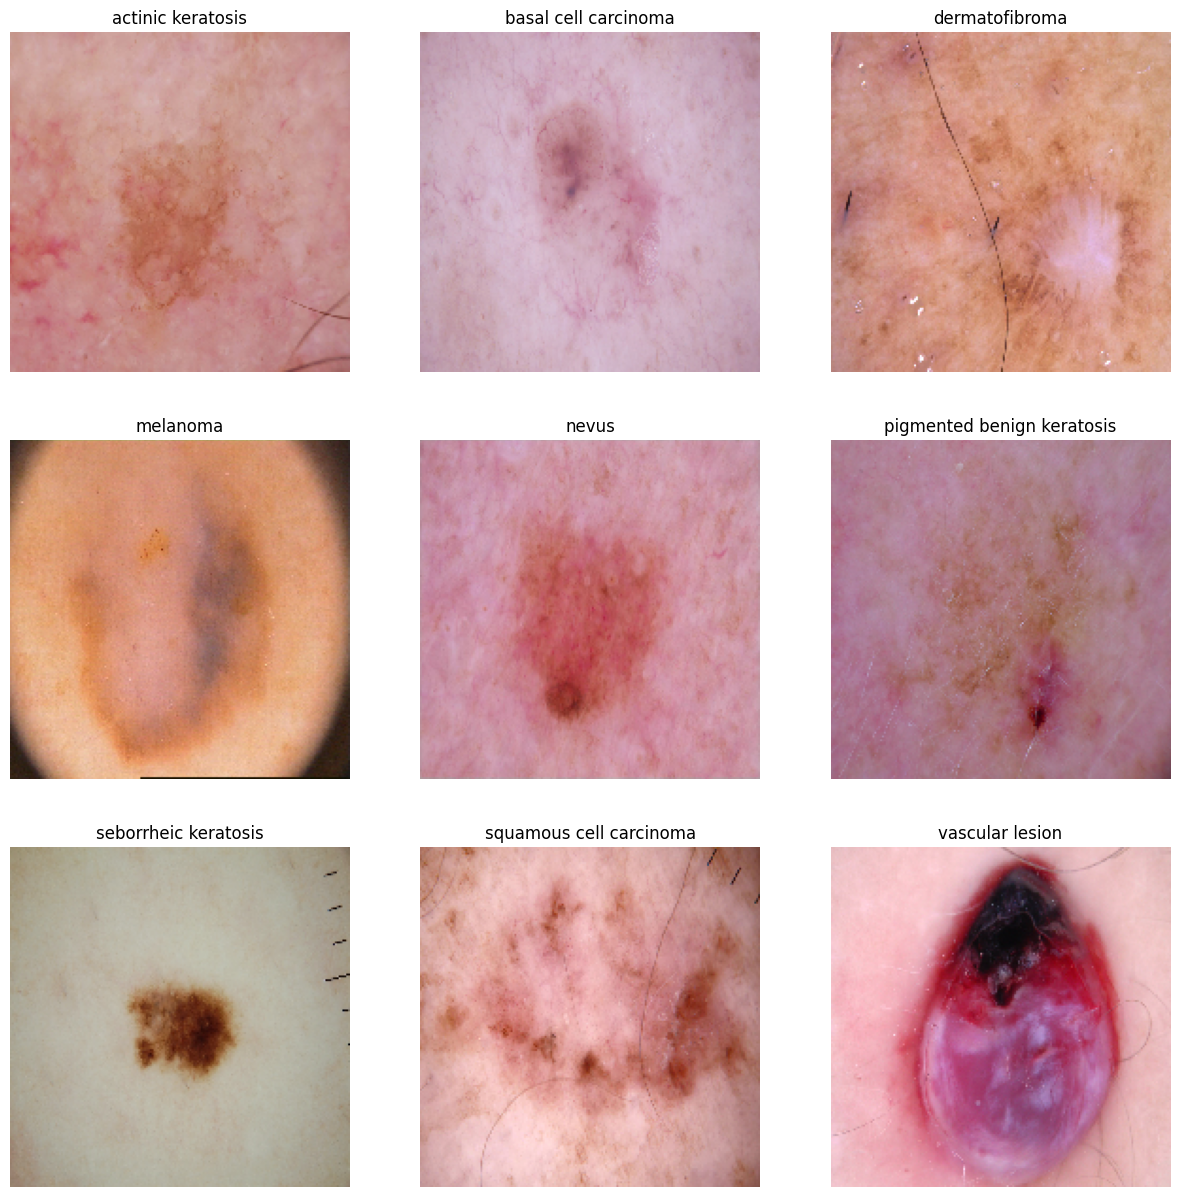

In [7]:
#data visualisation
class_names = train_images.class_names

#Dictionary to store the path of image as per the class
files_path_dict = {}

for c in class_names:
    files_path_dict[c] = list(map(lambda x:str(train_folder)+'/'+c+'/'+x,os.listdir(str(train_folder)+'/'+c)))

#Visualize image
plt.figure(figsize=(15,15))
index = 0
for c in class_names:
    path_list = files_path_dict[c][:1]
    index += 1
    plt.subplot(3,3,index)
    plt.imshow(load_img(path_list[0],target_size=(180,180)))
    plt.title(c)
    plt.axis("off")

In [8]:
#model building & training
model = Sequential()
total_class = len(class_names)
model.add(layers.experimental.preprocessing.Rescaling(1./255,input_shape=(180,180,3)))

#First layer
model.add(layers.Conv2D(32,kernel_size=(3,3),activation='relu'))
model.add(BatchNormalization())
model.add(layers.MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.25))

#Second Layer
model.add(layers.Conv2D(64,kernel_size=(3,3),activation='relu'))
model.add(BatchNormalization())
model.add(layers.MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.25))

#Third Layer
model.add(layers.Conv2D(128,kernel_size=(3,3),activation='relu'))
model.add(BatchNormalization())
model.add(layers.MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.25))

#dense layer followed by softmax
model.add(Flatten())
model.add(Dense(512, kernel_regularizer=l2(0.01)))
model.add(Activation('relu'))
model.add(Dropout(0.25))
model.add(Dense(total_class))
model.add(Activation('softmax'))

model.summary()

#initialize optimizer
model.compile(optimizer="Adam",loss="categorical_crossentropy",metrics=["accuracy"])

#fit the model
history = model.fit(train_images, validation_data=val_images, epochs=20)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 178, 178, 32)      896       
                                                                 
 batch_normalization (Batch  (None, 178, 178, 32)      128       
 Normalization)                                                  
                                                                 
 max_pooling2d (MaxPooling2  (None, 89, 89, 32)        0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 89, 89, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 87, 87, 64)        1

In [ ]:
#The training accuracy is 57% & the Validation accuracy is 23%, Clearly the model is Overfitting.

In [9]:
#Check number of images in ach class
image_count= []
for path in pathlib.Path(train_folder).iterdir():
  image_count.append(len([name for name in os.listdir(path)
                               if os.path.isfile(os.path.join(path, name))]))
  sub_folder = [name for name in os.listdir(train_folder)
                    if os.path.isdir(os.path.join(train_folder, name))]
  df = pd.DataFrame(list(zip(sub_folder,image_count)),columns =['Folder_Name', 'Image_Count'])

In [10]:
df
#There is a class imbalence observed. The seborrheic keratosis has very less number of images &
#the Pigmented benign keratosis has high number of images & Dominates the class proportion

,Folder_Name,Image_Count
0,vascular lesion,139
1,basal cell carcinoma,376
2,nevus,357
3,seborrheic keratosis,77
4,pigmented benign keratosis,462
5,dermatofibroma,95
6,actinic keratosis,114
7,melanoma,438
8,squamous cell carcinoma,181


In [11]:
#using aumentator to rectify class imbalences
#installing augmentator library
!pip install Augmentor

In [12]:
import Augmentor
str_train_folder = "/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/"
for i in class_names:
    p = Augmentor.Pipeline(str_train_folder + i)
    p.rotate(probability=0.5, max_left_rotation=5, max_right_rotation=10)
    p.flip_random(probability=0.5)
    p.sample(700)
#adding extra 700 sample images for each class

Initialised with 114 image(s) found.
Output directory set to /content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7BA5203777F0>: 100%|██████████| 700/700 [00:20<00:00, 34.15 Samples/s]


Initialised with 376 image(s) found.
Output directory set to /content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7BA53C39E890>: 100%|██████████| 700/700 [00:20<00:00, 34.36 Samples/s]


Initialised with 95 image(s) found.
Output directory set to /content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7BA520563940>: 100%|██████████| 700/700 [00:23<00:00, 30.32 Samples/s]


Initialised with 438 image(s) found.
Output directory set to /content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1024x768 at 0x7BA53C4FAC80>: 100%|██████████| 700/700 [01:16<00:00,  9.13 Samples/s]


Initialised with 357 image(s) found.
Output directory set to /content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output.

Processing <PIL.Image.Image image mode=RGB size=919x802 at 0x7BA53C6D59C0>: 100%|██████████| 700/700 [01:21<00:00,  8.59 Samples/s]


Initialised with 462 image(s) found.
Output directory set to /content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7BA53C5101C0>: 100%|██████████| 700/700 [00:16<00:00, 42.05 Samples/s]


Initialised with 77 image(s) found.
Output directory set to /content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7BA5277CA6B0>: 100%|██████████| 700/700 [00:37<00:00, 18.55 Samples/s]


Initialised with 181 image(s) found.
Output directory set to /content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7BA5277B7E20>: 100%|██████████| 700/700 [00:16<00:00, 41.22 Samples/s]


Initialised with 139 image(s) found.
Output directory set to /content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7BA52771D930>: 100%|██████████| 700/700 [00:16<00:00, 41.79 Samples/s]


In [13]:
#Re creating training & testing set after augmentation
train_images = keras.preprocessing.image_dataset_from_directory(train_folder, batch_size=32,
                                                               image_size=(180,180), label_mode='categorical',
                                                               seed=123,subset="training",
                                                               validation_split=0.2)

Found 8539 files belonging to 9 classes.
Using 6832 files for training.


In [14]:
val_images =tf.keras.preprocessing.image_dataset_from_directory(train_folder,batch_size=32,
                                                            image_size=(180,180), label_mode='categorical',
                                                            seed=123,subset="validation",
                                                            validation_split=0.2)

Found 8539 files belonging to 9 classes.
Using 1707 files for validation.


In [15]:
#Model Building after augmentation
#model building & training
model = Sequential()
total_class = len(class_names)
model.add(layers.experimental.preprocessing.Rescaling(1./255,input_shape=(180,180,3)))

#First layer
model.add(layers.Conv2D(32,kernel_size=(3,3),activation='relu'))
model.add(layers.MaxPool2D(pool_size=(2,2)))

#Second Layer
model.add(layers.Conv2D(64,kernel_size=(3,3),activation='relu'))
model.add(layers.MaxPool2D(pool_size=(2,2)))

#Third Layer
model.add(layers.Conv2D(128,kernel_size=(3,3),activation='relu'))
model.add(layers.MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.25))

#dense layer followed by softmax
model.add(Flatten())
model.add(Dense(128, kernel_regularizer=l2(0.01)))
model.add(Activation('relu'))
model.add(Dropout(0.25))
model.add(Dense(total_class))
model.add(Activation('softmax'))

print(model.summary())

#initialize optimizer
model.compile(optimizer="Adam",loss="categorical_crossentropy",metrics=["accuracy"])

#fit the model
model.fit(train_images, validation_data=val_images, epochs=20)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 178, 178, 32)      896       
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 89, 89, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_4 (Conv2D)           (None, 87, 87, 64)        18496     
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 43, 43, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_5 (Conv2D)           (None, 41, 41, 128)      

1/1 [==============================] - 1s 877ms/step
Actual Class basal cell carcinoma
Predictive Class basal cell carcinoma


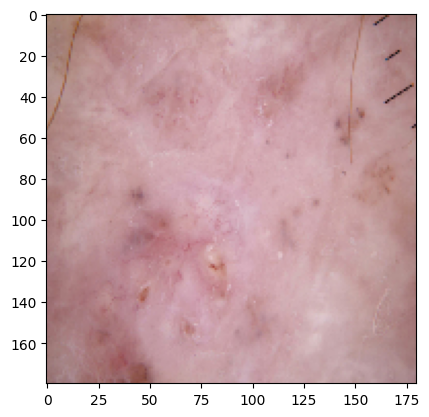

In [18]:
#verification of model
test_image = glob(os.path.join(test_folder, class_names[1], '*'))
test_image = load_img(test_image[-1],target_size=(180,180,3))
plt.imshow(test_image)
plt.grid(False)

img = np.expand_dims(test_image,axis=0)
pred = model.predict(img)
pred = np.argmax(pred)
pred_class = class_names[pred]
print("Actual Class "+ class_names[1] +'\n'+ "Predictive Class "+pred_class )

#predicted class = carcinoma & actual class = carcinoma, Model is verified to detect the type of cancer correctly